In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.inspection import permutation_importance
import shap
import pickle
import os
from boruta import BorutaPy

# Generate synthetic data
data, name_map = util.generate_data(size=500, seed=42)
num_cols = [c for c in data.columns[:-1] if len(data[c].unique()) > 2]
cat_cols = [c for c in data.columns[:-1] if len(data[c].unique()) == 2]

# Data pre-processing
X, y = data[data.columns[:-1]].copy(), data[data.columns[-1]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Train a GBT model
base_est = xgboost.XGBClassifier(tree_method='hist', importance_type='total_gain')
param_grid={'max_depth': [2, 3, 4], 'n_estimators': list(range(20, 41, 5)), 'reg_lambda': np.linspace(0, 500, 6)}
gscv = GridSearchCV(base_est, param_grid=param_grid)
gscv.fit(X, y)
xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

# Retrieve SHAP values
with open(os.path.join('..', 'data', 'shap_values.pickle'), 'rb') as fp:
    shap_values = pickle.load(fp)

/Users/michelelombardi/Library/Caches/pypoetry/virtualenvs/07-at-KRNohLwX-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# All Relevant Feature Selection

## Racapping Our Path So Far

**We started with a somewhat clear goal**

* Given data containing candidate correlates and a discrete target
* ...We aimed at identifying the most relevant correlates

**We applied a baseline approach (Lasso) to:**

* Obtain a surrogate for our data-generation process
* Analyze the impact of each candidate correlate (feature)
* Identify the most relevant correlates

**Our baseline turned out to be largely insufficient, so we:**

* Trained a non-linear model to obtain a more reliable surrogate
* Learn to assess importance via a permutation-based method
* Learned to explain individual examples via SHAP

**We still have a couple of major open problems...**

## Open Problems

**There's a mistmatch between local and global explanations**

* We are using SHAP to assess local feature effects 
* ...And permutation importance for global feature effects

As a side effect, there may be inconsistences in our analysis

**We still don't know how to identify the most relevant features**

* Like in the Lasso appproach we could think of using a threshold
* ...But we still don't know how such threshold should be calibrated

> **It's time that we fix both of them**

## Global Feature Analysis via SHAP

**SHAP explanations can be aggreated to get global importance scores**

By default, this is done by averaring absolute SHAP values:

$$
\bar{\phi}_j(x) = \frac{1}{n} \sum_{i=1}^m |\phi_j(x_i)|
$$

* Other aggregation functions can also be used (e.g. max)

**By using aggregated SHAP scores**

...We can attempt to identify the most important correlates

* I.e. we can used SHAP scores like we were using permutation importances
* In fact, both approaches are sound and well defined

## Global Feature Analysis via SHAP

**The SHAP library provide convenience functions to plot aggregated values**

Here's how to plot mean (absolute) SHAP values:

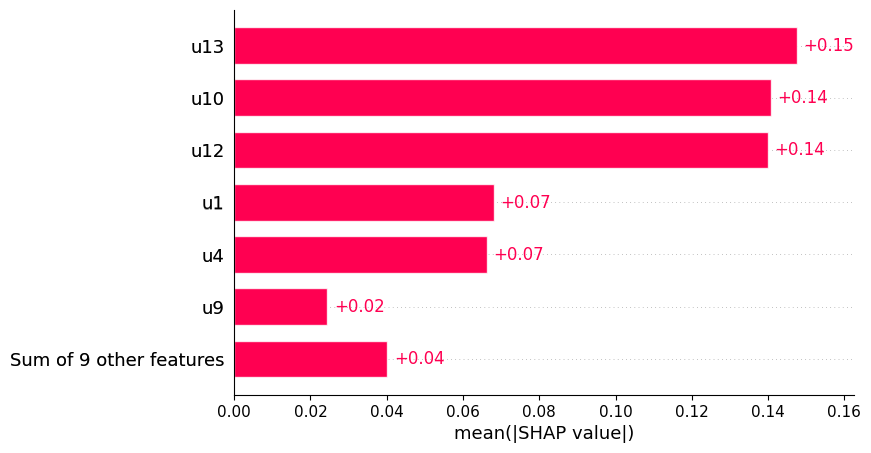

In [2]:
shap.plots.bar(shap_values, max_display=7)

## Global Feature Analysis via SHAP

**The SHAP library provide convenience functions to aggregated values**

Here's how to display the maximum (absolute) SHAP values:

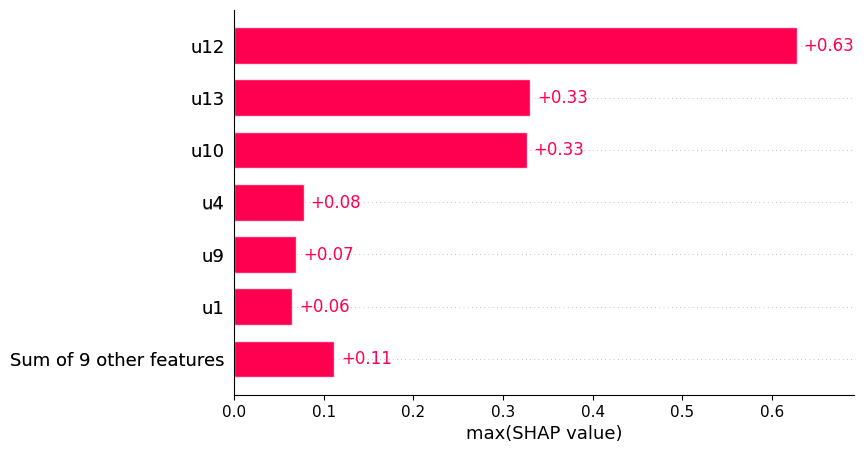

In [3]:
shap.plots.bar(shap_values.max(0), max_display=7)

## Semantics for Feature Selection

**A viable approach for feature selection consists in solving:**

$$
\mathop{\mathrm{argmin}}_{\mathcal{S} \subseteq \mathcal{X}} \left\{ |\mathcal{S}| : \hat{y} = \hat{f}_{\mathcal{S}}\left(x_{\mathcal{S}}\right), L\left(y, \hat{y}\right) \leq \theta \right\}
$$

Where $x, y$ denote all the training data. Intuitively:

* We search for the smallest subset of features $\mathcal{S}$
* ...Such that a model $\hat{f}_{\mathcal{S}}$ trained over only over them
* ...Still has an acceptable (cross-validation) accuracy

Heuristics (e.g. greedy search) can be used to improve scalability

**This optimization-driven approach**

* ...Can be customized by adjusting the constraint and cost function
* ...Can reduce data storage and location costs on the deployed model

## Semantics for Feature Selection

**If we care just about _cost and accuracy_, the optimization approach is perfect**

> **But it is not suitable for our current case study...<br> Can you tell why?**

**For a number of reasons:**

* We care about finding _all the relevant features_, not a minimal set
* How should the accuracy threshold be calibrated?
* What about the noise induced by retraining?

If we wish to use ML for data analysis, we need another approach

**...In particular, we will rely on _statistical hypothesis testing (HT)_**

## Statistical Hypothesis Testing

**HT builds evidence for a hypothesis by _refuting_ a competing one:**

We start with:

- a random variable $X$
- a hypothesis $H(X)$

We define:

- a competing _null hypothesis_ $H_0(X)$
- a experimental statistics $T[X]$, e.g. an expected value, an estimate probability

**In most cases:**

* $H_0$ is often the negation of our original hypothesis
* $T[X]$ is a quantity that, if large enough, supports our hypothesis

## Statistical Hypothesis Testing

**We reject the null hypothesis by checking what happens _when $H_0$ is true_**

In particular, we need to compute:

* the _empirical_ value $t$ of $T[x \mid H_0]$ on a sample $x$
* the _theoretical_ probability of the computed value, i.e. $P(T[X \mid H_0] \geq t)$

The former usually requires dedicated experiments (e.g. with a control group) 

**The probability $P(T[X \mid H_0] = t)$ is called a $p$-value**

* If $p$ is small enough, we can say that $H_0$ is likely false
* ...Which in turn provides support for our original hypothesis

<div class=big>
    <small>This is probably very confusing...</small><br>
    Let's make an example for our case
</div>

## Hypothesis, Data, and Null-Hypothesis

**First, we need to define our _variable_ and _hypothesis_**

We care about identifying correlates, so a possible choice might be:

* The variable will be the pair $(X, Y)$, i.e. observable and target
* $H \equiv \text{"} X \text{ is important to predict } Y$, according to some indicator $r[X, Y]$

**Now we need a competing _null hypothesis_**

A good choice might be $H_0 \equiv \text{"} \text{the importance of } X \text{ is due to chance}$

* In this case, refuting $H_0$ lends directly support for $H$
* Other situations might be more complicated

> **The real difficulty is defining the _test statistics_**

## Towards a Test Statistics

**Let's consider the _desired properties for the test statistics_**

* It should be related to both $H$ and $H_0$
* It should be a measurable experimental outcome
* We should be able to run experiments, assuming that $H_0$ is true
* We shoudd be able to compute probabilities, assuming that $H_0$ is true

**...And let's consider out situation**

* We care about importance, both in $H$ and in $H_0$
* We can measure importance via the $r[X, Y]$ indicator
* We already have a sample $(x, y)$ where $r$ has a larg-ish value

...But what about the other desired properties?

## Towards a Test Statistics

**Let's consider this inequality**

$$
r[\tilde{x}, \tilde{y}] \leq r^* \qquad \text{ with: } r^* = r[x, y]
$$

* $r[x, y]$ is the correlation value measured on our data
* $(\tilde{x}, \tilde{y})$ is a sample from $(\tilde{X}, \tilde{Y})$
* ...Where $(\tilde{X}, \tilde{Y})$ are similar to $(X, Y)$, but _uncorrelated_

Later, we will need to find a way to sample from $(\tilde{X}, \tilde{Y})$

**Then:**

* If $X$ and $Y$ are correlated, we would expect the inequality to be usually true
* Otherwise, the inequality might be true or false, depending on chance

## Towards a Test Statistics

**In other words, we use a statistics the expectation**

...Which can be estimated via the expectation:

$$
T[X, Y \mid H_0] \equiv \sum_{i = 1}^m P(r[\tilde{X}, \tilde{Y}] \leq r^*)
$$

* I.e. the number of times the inequality holds when sampling $m$ times $(\tilde{X}, \tilde{Y})$

**For this statistics, we need do two things**

* Computing the theoretical distribution $P(T[X, Y \mid H_0])$
* Computing the empirical value $P(T[x, y \mid H_0])$

## Test Statistic and Theoretical Probability

**Let's consider again our test $r[\tilde{X}, \tilde{Y}] \leq r^*$**

Since it has a binary outcome, it will follow a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)

* If we assume that the result is due to chance...
* ...Then the associated probability should be $^1/_2$

**If we make repeated experiments with samples $(\tilde{x}, \tilde{y})$**

...The _number of observed events $r[\tilde{x}, \tilde{y}] \leq r^*$_ will follow a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

* Given the number of experiments $n$
* ...The probability of $T[X, Y \mid H_0]$ should be $B(n, {^1/_2})$

**Hence, $B(n, {^1/_2})$ is the theoretical distribution under $H_0$ for our statistics**

## Theoretical Probability Computation

**We can easily compute and plot the distribution**

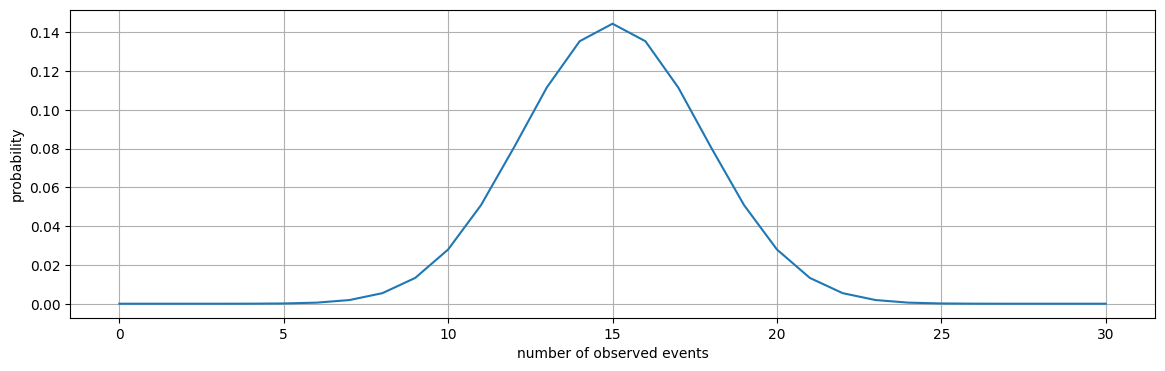

In [11]:
util.binomial_plot(n=30, p=0.5, figsize=figsize)

* This tells us how likely we are to observe a certain number of events
* ...Assuming that the null hypothesis is true

<div class=big>
...But how do we run the experiments?<br>
<small>We need to simulate lack of correlation in $(X, Y)$<br>...Without additional assumptions</small>
</div>

## Empirical Probability Computation

**We can use a Monte-Carlo approach**

The trick is once again relying on _permutations_

* If we shuffle the values of one variable (say the values $x$ of $X$)
* ...We can get a correlation with $Y$ only by chance
* ...But we otherwise preserve the distribution of the sample

**We can mitigate sampling noise via repeated experiments**

* Then, we take our _empirically observed_ number $t = T[X, Y \mid H_0]$ of events
* ...And we match it against the theoretical probability

Any sufficiently low probability will allow use to reject $H_0$

## $p$-Value and the Statistical Test

**Basically, there is a "target interval" in the distribution**

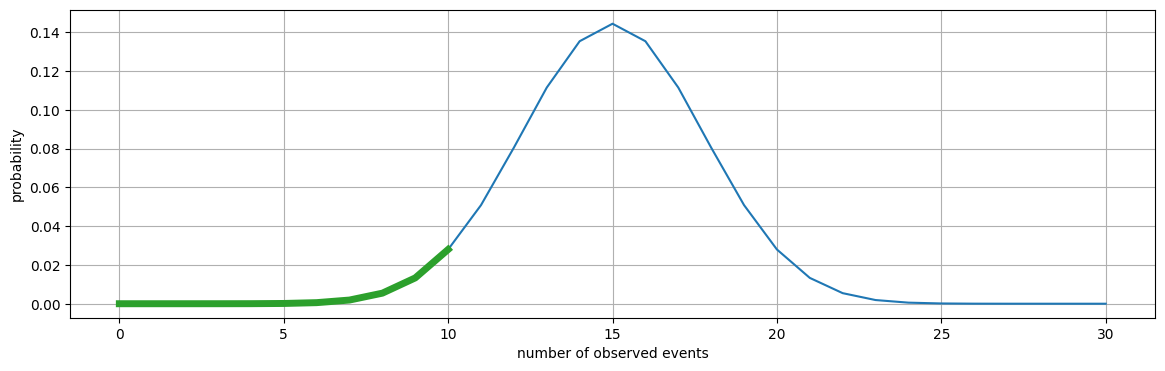

In [12]:
util.binomial_plot(n=30, p=0.5, l_alpha=0.05, figsize=figsize)

* For any value $t$ in the interval, we have $P(T[X, Y \mid H_0] = t) \leq 1-\alpha$
* ...Where $\alpha$ is our desired _confidence level_

## $p$-Value and the Statistical Test

**Basically, there is a "target interval" in the distribution**

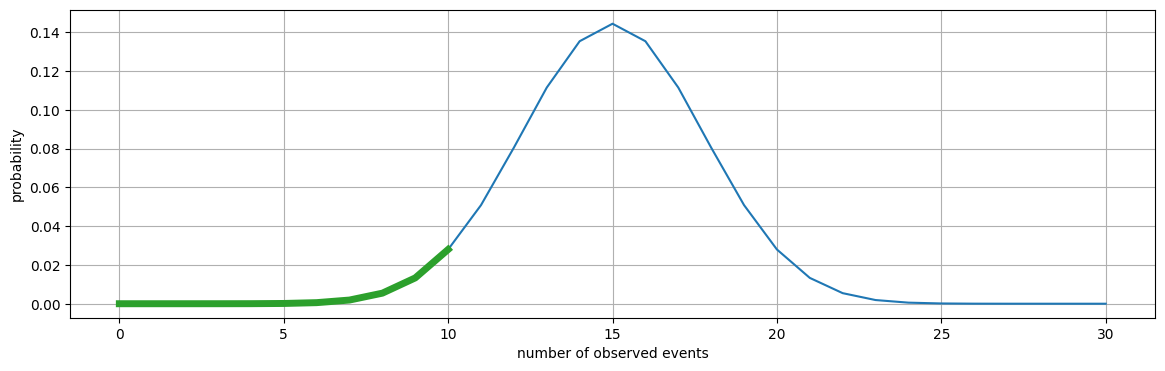

In [13]:
util.binomial_plot(n=30, p=0.5, l_alpha=0.05, figsize=figsize)

* In practice it's more common to compute the _$p$-value_ $P(T(X, Y) \geq t \mid H_0)$
* ...Which can then be immediately compared with $1 - \alpha$

## Back to the Procedure Description

**The procedure should be clearer now**

Let's recap the steps:

* We define our random variable $X$ the hypothesis $H$
* We formulate a competing _null hypothesis $H_0$_
* We define a _test statistics_ $T[X]$, linked to $H$ and $H_0$
* Assuming that $H_0$ holds:
  - We define the theoretical probability $P(T[X, Y \mid H_0])$
  - We compute the empirical value $T[x, y \mid H_0]$
* We compute the $p$ value $P(T[x, y \mid H_0])$
* If $p \leq 1 - \alpha$ for some confidence $\alpha$, we _reject the null hypothesis_

## Testing a Hypothesis and Its Negation

**In our case, the method works also for testing the _opposite_ hypothesis**

* Our hypothesis becomes $\neg H * \equiv \text{"} X \text{ is not important to predict } Y$
* The null hypothesis is the same as before
* The test statistics is just $n-T[X, Y \mid H_=]$, for the same $T$ as before

Then we can proceed as in the previous case

**Since we are relying on the same test statistics**

...We can use the same set of experiments to test both hypotheses

* Intuitively, in both cases we look at the number of times $r[\tilde{x}, \tilde{y}] \leq r^*$
* If hits is sufficiently high, it's likely that the $H$ holds
* ...If this is sufficiently low, it's likely that $\neg H$ holds

## Testing a Hypothesis and Its Negation

**In other words, we will end up having _two target intervals_**

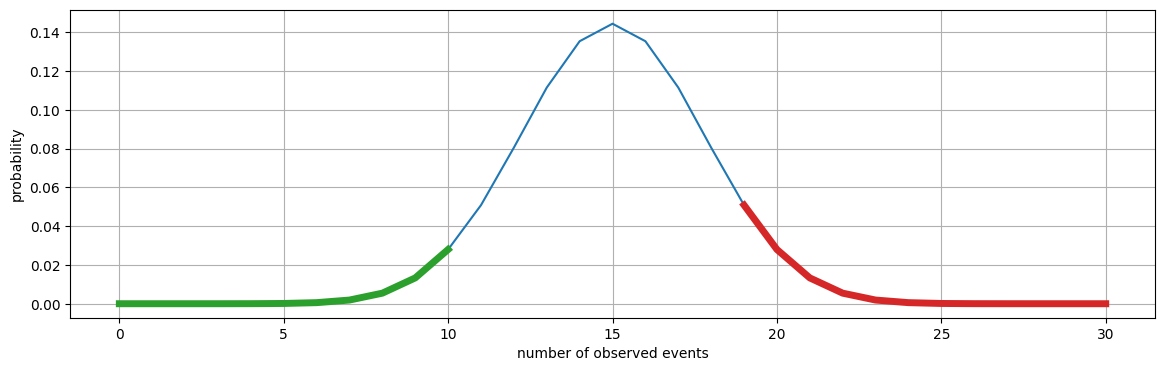

In [14]:
util.binomial_plot(n=30, p=0.5, l_alpha=0.05, r_alpha=0.05, l_color='tab:green', r_color='tab:red', figsize=figsize)

* If $T$ is in the green region, we support $H$ (e.g. confirmed importance)
* If $T$ is in the red region, we support $\neg H$ (e.g. confirmed non-importance)
* If $T$ lands in the center region, we support no claim

## Boruta

**The approach we have just seen is the backbone of [the Boruta algorithm](https://www.jstatsoft.org/article/view/v036i11)**

* The Boruta algorithm is a SotA feature selection method
* ...That relies in statistical HT to determine relevant features

**Like in our analysis, the method relies on surrogate models**

...And in particular on tree ensembles (the name refers to [a Slavic forest spirit](https://en.wikipedia.org/wiki/Devil_Boruta))

* As a consequence, the algorithm can deal with non-linear correlations
* ...And accounts for interactions between multiple features

**Boruta is an all-relevant feature selector**

* This makes it particularly well suited for scientific analyses
* ...But it can be used to reduce data collection costs or improve generalization

## Tested Hypothesis in Boruta

**Boruta relies on a measure of feature importance**

* The original algorithm and the [BorutaPy package](https://github.com/scikit-learn-contrib/boruta_py) use permutation importance
* An unmaintained [version based on SHAP](https://github.com/Ekeany/Boruta-Shap) is also available

In both cases, importance is computed w.r.t. a reference dataset

**The hypothesis $H$ being tested is more general than ours and consists in:**

> <i>"Feature $j$ is important among those in the dataset,<br> according to the chosen metric"</i>

* This is bit more general than the one we considered
* ...And it require as slighly more sophisticated test statistics

## Test Statistics in Boruta

**The main idea is stil to rely on permuted features**

Let $(x, y)$ be our original dataset

* First, we _augmented_ it by introducing permuted versions $\tilde{X}$ of all features
* These are called _shadow features_ by the algorithm. Let their values be $\tilde{x}$

Then, we train a predictive model on $(x, \tilde{x}, y)$

**Let $\phi_j((x,\tilde{x}), y)$ be the importance of feature $j$, on the augmented dataset**

* If the feature is important, its $\phi_j$ should beat the shadow features
* Therefore, we can consider the event

$$
\phi_j((x, \tilde{x}), y) > \max_{j \in \tilde{X}} \phi_j((x, \tilde{x}), y)
$$

## Test Statistics in Boruta

**Then the testing statistics $T$ is similar to the one we used:**

* The algorithms performs multiple experiments (retraining the model)
* ...And counts the number of times the event is satisfied ("hits")

**The thereotical distribution for $T$ under $H_0$ is _mostly_ a binomial**

* The algorithm needs to apply some _statistical corrections_
* ...Since we are testing multiple features together (we have a $\max$)

**Boruta tests both the positive and negative hypothesis**

Therefore, at the end of the process:

* Some features will be _confirmed important_
* Some features will be _confirmed unimportant_
* Some features will be remain _tentative_

## Using Boruta in Practice

**We'll use Boruta through the BorutaPy package**

In [20]:
bfs = BorutaPy(xbm, n_estimators='auto', max_iter=100, verbose=0, random_state=42)
bfs.fit(X=X, y=y);

* We can choose how many samples to use
* The algorithm also determines the best number of estimators

**Let's see which features have been selected**

In [35]:
print('Confirmed important:', X.columns[bfs.ranking_ == 1].values)
print('Uncomfirmed:', X.columns[bfs.ranking_ == 2].values)
print('Confirmed unimportant:', X.columns[bfs.ranking_ > 2].values)

Confirmed important: ['u1' 'u10' 'u12' 'u13']
Uncomfirmed: ['u4']
Confirmed unimportant: ['u0' 'u2' 'u3' 'u5' 'u6' 'u7' 'u8' 'u9' 'u11' 'u14']


<div class=big>
Ok, but... Did it work?<br>
</div>

## What we Have Discovered

**So far, by using Boruta we found that:**

* There seem to be 4 relevant features, i.e. $U_1, U_{10}, U_{12}, U_{13}$

**By inspecting the data we found that:**

* $U_{12}$ and $U_{13}$ are roughly Normally distributed
* $U_1$ is not Normally distributed
* $U_{10}$ is binary

**By using SHAP we found that:**

* $U_{13}$ has a mostly monotonic effect
* $U_{12}$ has a complex effect, which seems to be modulated by $U_{10}$
* $U_1$ seems to have mostly an anti-monotonic effect

<div class=big>
We can now inspect the ground truth process<br>
<small>So we can check whether our results actually hold</small>
</div>

## Checking the Ground Truth

**The ground-truth process is described by this causal graph:**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

* The $Y$ variable (in <strong style="color: DeepSkyBlue">blue</strong>) is the target
* The variables in <strong>black</strong> are those that are relevant
* The variables in <strong style="color: DimGray">gray</strong> are not observable, i.e. latent
* The variables in <strong style="color: FireBrick">red</strong> are irrelevant

## Checking the Ground Truth

**The process was engineered to contain several classical cases**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

$X_2$ is a _mediator_ beween $X_0, X_1$ and $Y$

* The variable partially hides the effect of $X_0$ and $X_1$
* If it does that completely, even Boruta cannot mark $X_0$ and $X_1$ as important
* Depending on the use case, this might be an issue

## Checking the Ground Truth

**The process was engineered to contain several classical cases**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

$X_2$ is also a complete mediator for $Z_0$

* ...But in this case it is a good thing!
* $Z_0$ is not observed, but we can account for that at least indirectly

## Checking the Ground Truth

**The process was engineered to contain several classical cases**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

$Z_1$ is a _confounder_ and causes a correlation between $X_1$ and $X_0$

* It is totally mediated by $X_1$, which is a good thing
* ...But it also causes a correlation between $X_0$ and $X_4$
* This might trick a model into considering $X_4$ as important

## Checking the Ground Truth

**In detail, the data is generated as follows:**

$$\begin{align}
Z_0 & \sim \mathcal{N}(\mu=0, \sigma=1.5) \\
Z_1 & \sim \mathcal{N}(\mu=0, \sigma=1) \\
X_0 & \sim \mathcal{N}(\mu=0, \sigma=1) + Z_1 \\
\log X_1 & \sim \mathcal{N}(\mu=0, \sigma=1) \\
X_2 & = {^1/_2} (X_0 + X_1) + Z_0 \\
X_3 & \sim B(p=0.6) \\
\text{logit}(Y) & \sim (-1+2 X_3) X_2 + 0.4 X_0 - 0.4 X_1
\end{align}$$

* All other variables are follow either a Normal or Bernoulli distribution
* ...And they have sparse correlations among themselves

## Checking the Ground Truth

**Now let's check how accurate our importance estimate is:**

<center>
    <img src="assets/causal_graph.png" width="30%">
</center>

In [37]:
print(f'The accepted feature are {X.columns[bfs.ranking_ == 1].values}')
print(f'...Which correspond to {[name_map[f] for f in X.columns[bfs.ranking_ == 1].values]}')

The accepted feature are ['u1' 'u10' 'u12' 'u13']
...Which correspond to ['X1', 'X3', 'X2', 'X0']


## What we Have Discovered

**Now, let's check our findings, with the due substitutions:**

* The relevant features are $X_0, X_1, X_2, X_3$ $\rightarrow$ **correct!**
* All claims on distributions $\rightarrow$ **mostly correct!**
  - $X_2$ is a sum of 3 variables, two of which are Normal
* $X_0$ has a mostly monotonic effect $\rightarrow$ **correct!**
  - Direct monotonic effect on $Y$ + a complex one mediated by $X_2$
* $X_1$ has a mostly anti-monotonic effect $\rightarrow$ **correct!**
  - Direct anti-monotonic effect on $Y$ + a complex one mediated by $X_2$
* $X_2$ has complex effect modulated by $X_3$ $\rightarrow$ **correct!**
  - $X_3$ decides the sign of the $X_2$ contribution

## A Few Final Remarks

**ML models are not just for prediction!**

* They can be used for generation, anomaly detection, decision support
* ...And also as tools for a scientific analysis!

**Explainability is an important topic in AI**

* It is one of the main approaches to make an AI model _transparent_
* This critical when AI systems need to interact with human users
* ...And for some domains it is also required by existing regulations

**Beware of correlated features**

* Strongly correlated features (e.g mediated-mediator) may mislead algorithms
* Dealing with those is still a partially open problem!